# cosine similarity

In [1]:
from __future__      import division
from IPython.display import display
from matplotlib      import pyplot as plt
%matplotlib inline

import numpy  as np
import pandas as pd
import random, sys, os, re

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cross_validation import train_test_split

from sklearn.cross_validation import StratifiedKFold
from sklearn.grid_search      import RandomizedSearchCV, GridSearchCV
from sklearn.cross_validation import cross_val_predict, permutation_test_score

In [2]:
SEED   = 97
scale  = False 
minmax = False
norm   = False
nointercept = True
engineering = False

N_CLASSES = 2

submission_filename = "../submissions/submission_cosine_similarity.csv"

# Load the training data

In [3]:
from load_blood_data import load_blood_data

y_train, X_train = load_blood_data(train=True, SEED   = SEED, 
                                               scale  = scale,
                                               minmax = minmax,
                                               norm   = norm,
                                               nointercept = nointercept,
                                               engineering = engineering)

# Train/Valid split

In [4]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.33, random_state=SEED)

# Fit the "model"

In [5]:
from sklearn.metrics import confusion_matrix
y_true = y_valid
scores = []
for how_many in np.arange(50)+1:
    y_pred = []
    for i in range(len(X_valid)):
        top_how_many = cosine_similarity(X_valid.values[i:i+1], X_train.values).argsort()[0][::-1][:how_many]
        if np.mean([y_train[ii] for ii in top_how_many]) < 0.51:
            y_pred.append(0)
        else:
            y_pred.append(1)
    cm = confusion_matrix(y_true, y_pred, labels=None)
    scores.append(round(np.trace(cm)/float(np.sum(cm)),4))
    
best_k = np.argmax(scores)+1
print("best_k {}".format(best_k))

best_k 19


# Training set predictions

In [6]:
how_many = best_k
y_pred = []
for i in range(len(X_valid)):
    top_how_many = cosine_similarity(X_valid.values[i:i+1], X_train.values).argsort()[0][::-1][:how_many]
    if np.mean([y_train[ii] for ii in top_how_many]) < 0.5:
        y_pred.append(0)
    else:
        y_pred.append(1)

[[134   6]
 [ 34  17]]


/home/george/.local/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


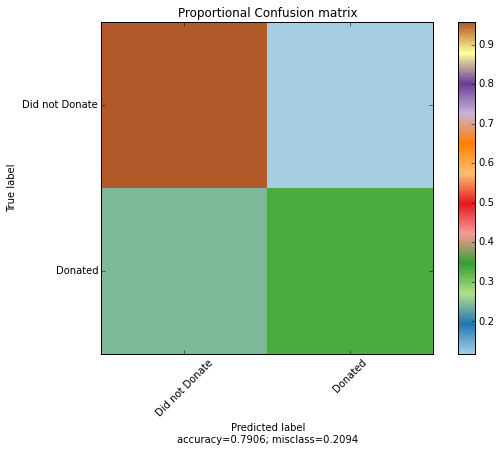

Accuracy 0.7906, mis-class rate 0.2094


In [7]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred, labels=None)
print cm

try:
    from sklearn_utilities import plot_confusion_matrix
except:
    import imp, os
    util = imp.load_source('sklearn_utilities', os.path.expanduser('~/Dropbox/Python/sklearn_utilities.py'))
    from sklearn_utilities import plot_confusion_matrix


plot_confusion_matrix(cm, ['Did not Donate','Donated'])

accuracy = round(np.trace(cm)/float(np.sum(cm)),4)
misclass = 1 - accuracy
print("Accuracy {}, mis-class rate {}".format(accuracy,misclass))

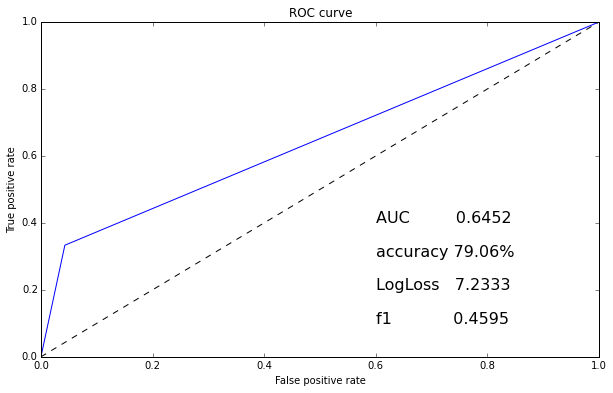

In [8]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.metrics import f1_score

fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=None)


plt.figure(figsize=(10,6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)

plt.text(x=0.6,y=0.4,s="AUC         {:.4f}"\
         .format(roc_auc_score(y_true, y_pred, average='macro')),
        fontsize=16)

plt.text(x=0.6,y=0.3,s="accuracy {:.2f}%"\
         .format(accuracy*100),
        fontsize=16)

plt.text(x=0.6,y=0.2,s="LogLoss   {:.4f}"\
         .format(log_loss(y_true, y_pred)),
        fontsize=16)

plt.text(x=0.6,y=0.1,s="f1            {:.4f}"\
         .format(f1_score(y_true, y_pred)),
        fontsize=16)

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

# --------------------------------------------------------------------------------------------

# Test Set Predictions

## Re-read the training data

In [35]:
X_train = None; X_valid = None
y_train = None; y_valid = None

In [36]:
from load_blood_data import load_blood_data

y_train, X_train = load_blood_data(train=True, SEED   = SEED, 
                                               scale  = scale,
                                               minmax = minmax,
                                               norm   = norm,
                                               nointercept = nointercept,
                                               engineering = engineering)

## Read the test data

In [37]:
from load_blood_data import load_blood_data

X_test, IDs = load_blood_data(train=False, SEED   = SEED, 
                                           scale  = scale,
                                           minmax = minmax,
                                           norm   = norm,
                                           nointercept = nointercept,
                                           engineering = engineering)

# Predict the test set with the "model"

In [38]:
how_many = best_k
y_pred = []
for i in range(len(X_test)):
    top_how_many = cosine_similarity(X_test.values[i:i+1], X_train.values).argsort()[0][::-1][:how_many]
    if np.mean([y_train[ii] for ii in top_how_many]) < 0.5:
        y_pred.append(0)
    else:
        y_pred.append(1)

In [39]:
donate_probs = [0.65 if x>0 else 1-0.65 for x in y_pred]

In [40]:
print(y_pred[:10])
print(donate_probs[:10])

[0, 0, 0, 0, 1, 1, 0, 0, 0, 0]
[0.35, 0.35, 0.35, 0.35, 0.65, 0.65, 0.35, 0.35, 0.35, 0.35]


# Create the submission file

In [41]:
assert len(IDs)==len(donate_probs)

f = open(submission_filename, "w")

f.write(",Made Donation in March 2007\n")
for ID, prob in zip(IDs, donate_probs):
    f.write("{},{}\n".format(ID,prob))
    
f.close()